In [506]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math

In [507]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-BRYN\SERVER1;'
                      'Database=AdventureWorks2019;'
                      'Trusted_Connection=yes;')

In [508]:
cursor = conn.cursor()

In [509]:
query = 'SELECT * FROM Sales.byState'

In [510]:
SalesbyState = pd.read_sql(query, conn)

C:\Users\new user\AppData\Local\Temp\ipykernel_9952\1398768180.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SalesbyState = pd.read_sql(query, conn)


In [511]:
print(SalesbyState)

   StateProvinceCode          2011          2012          2013          2014  \
0                TX   5.811520e+05  2.776677e+06  2.613550e+06  6.850290e+05   
1                WI   6.836563e+04  1.847705e+05  1.618765e+05  7.384774e+04   
2                IN   1.303852e+05  5.877533e+05  3.045870e+05  5.066306e+04   
3                IL   2.151107e+05  2.892926e+05  8.781222e+04  1.855259e+04   
4                NH   8.403769e+04  7.704541e+05  7.484627e+05  2.072335e+05   
5                MD   0.000000e+00  0.000000e+00  0.000000e+00  2.337270e+03   
6                CO   1.334465e+05  9.377355e+05  1.053285e+06  2.714472e+05   
7                MI   1.322443e+05  5.378980e+05  5.662532e+05  2.114867e+05   
8                VA   1.169539e+05  2.868539e+05  2.032302e+05  5.283453e+04   
9                ME   0.000000e+00  2.942043e+05  1.678962e+05  1.776504e+04   
10               SC   9.187835e+04  8.632118e+04  3.009531e+04  6.308982e+03   
11               RI   3.427424e+03  9.90

In [512]:
# The top 3 states have sales an order of magnitude higher than the rest so I will compare them seperately

SalesbyState['StateProvinceCode'] = SalesbyState['StateProvinceCode'].str.strip()  # Remove spaces
filtered = SalesbyState[SalesbyState['StateProvinceCode'].isin(['CA', 'TX', 'WA'])]  # Filter states
Top3rev = filtered.groupby('StateProvinceCode', as_index=False)['TotalSales'].sum()  # Group by state
Top3rev = Top3rev.sort_values('TotalSales', ascending=False)
print(Top3rev)


  StateProvinceCode    TotalSales
0                CA  1.547853e+07
2                WA  9.421963e+06
1                TX  6.656408e+06


C:\Users\new user\AppData\Local\Temp\ipykernel_9952\4040546099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='StateProvinceCode', y='TotalSales', data=Top3rev, palette='tab10')


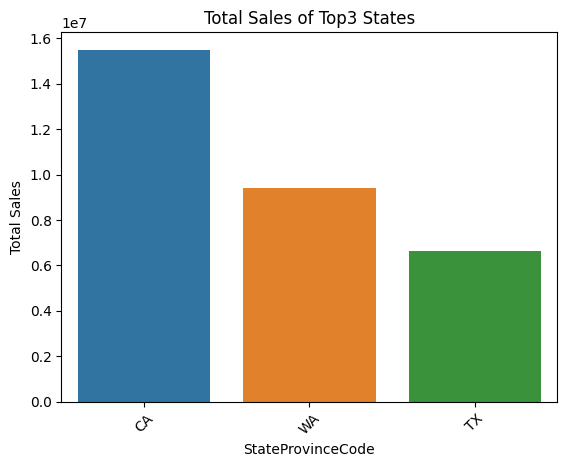

In [513]:
# Create the barplot with a colormap from seaborn
sns.barplot(x='StateProvinceCode', y='TotalSales', data=Top3rev, palette='tab10')

# Add labels and title
plt.xlabel('StateProvinceCode')
plt.ylabel('Total Sales')
plt.title('Total Sales of Top3 States')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Sets the top 3 states to a negligible value so they don't skew the colour distribution on my map

SalesbyState.loc[20, 'TotalSales'] = 1e+05
SalesbyState.loc[12, 'TotalSales'] = 1e+05
SalesbyState.loc[0, 'TotalSales'] = 1e+05

In [515]:
# Uses wget to pull the geospatial data

# wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

In [516]:
# Retrieve the shapefile from the download folder which contains the states geometry

gdf = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')
print(gdf)

   STATEFP   STATENS     AFFGEOID GEOID STUSPS  \
0       28  01779790  0400000US28    28     MS   
1       37  01027616  0400000US37    37     NC   
2       40  01102857  0400000US40    40     OK   
3       51  01779803  0400000US51    51     VA   
4       54  01779805  0400000US54    54     WV   
5       22  01629543  0400000US22    22     LA   
6       26  01779789  0400000US26    26     MI   
7       25  00606926  0400000US25    25     MA   
8       16  01779783  0400000US16    16     ID   
9       12  00294478  0400000US12    12     FL   
10      31  01779792  0400000US31    31     NE   
11      53  01779804  0400000US53    53     WA   
12      35  00897535  0400000US35    35     NM   
13      72  01779808  0400000US72    72     PR   
14      46  01785534  0400000US46    46     SD   
15      48  01779801  0400000US48    48     TX   
16      06  01779778  0400000US06    06     CA   
17      01  01779775  0400000US01    01     AL   
18      13  01705317  0400000US13    13     GA   


In [517]:
# Standardise the State codes so they can be merged

SalesbyState['StateProvinceCode'] = SalesbyState['StateProvinceCode'].str.strip()

In [518]:
# Merge the geometry data with my revenues from AdventureWorks

gdf = gdf.merge(SalesbyState,left_on='STUSPS',right_on='StateProvinceCode')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,StateProvinceCode,2011,2012,2013,2014,TotalSales
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...",MS,198997.6314,287715.4916,36486.8804,82.5900,5.232826e+05
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",NC,47532.6494,228060.5915,405441.9828,150459.9996,8.314952e+05
2,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",VA,116953.8582,286853.8898,203230.2289,52834.5311,6.598725e+05
3,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",MI,132244.2817,537897.9564,566253.2476,211486.7238,1.447882e+06
4,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",MA,32564.1972,35144.3060,20152.2439,21542.2260,1.094030e+05


C:\Users\new user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


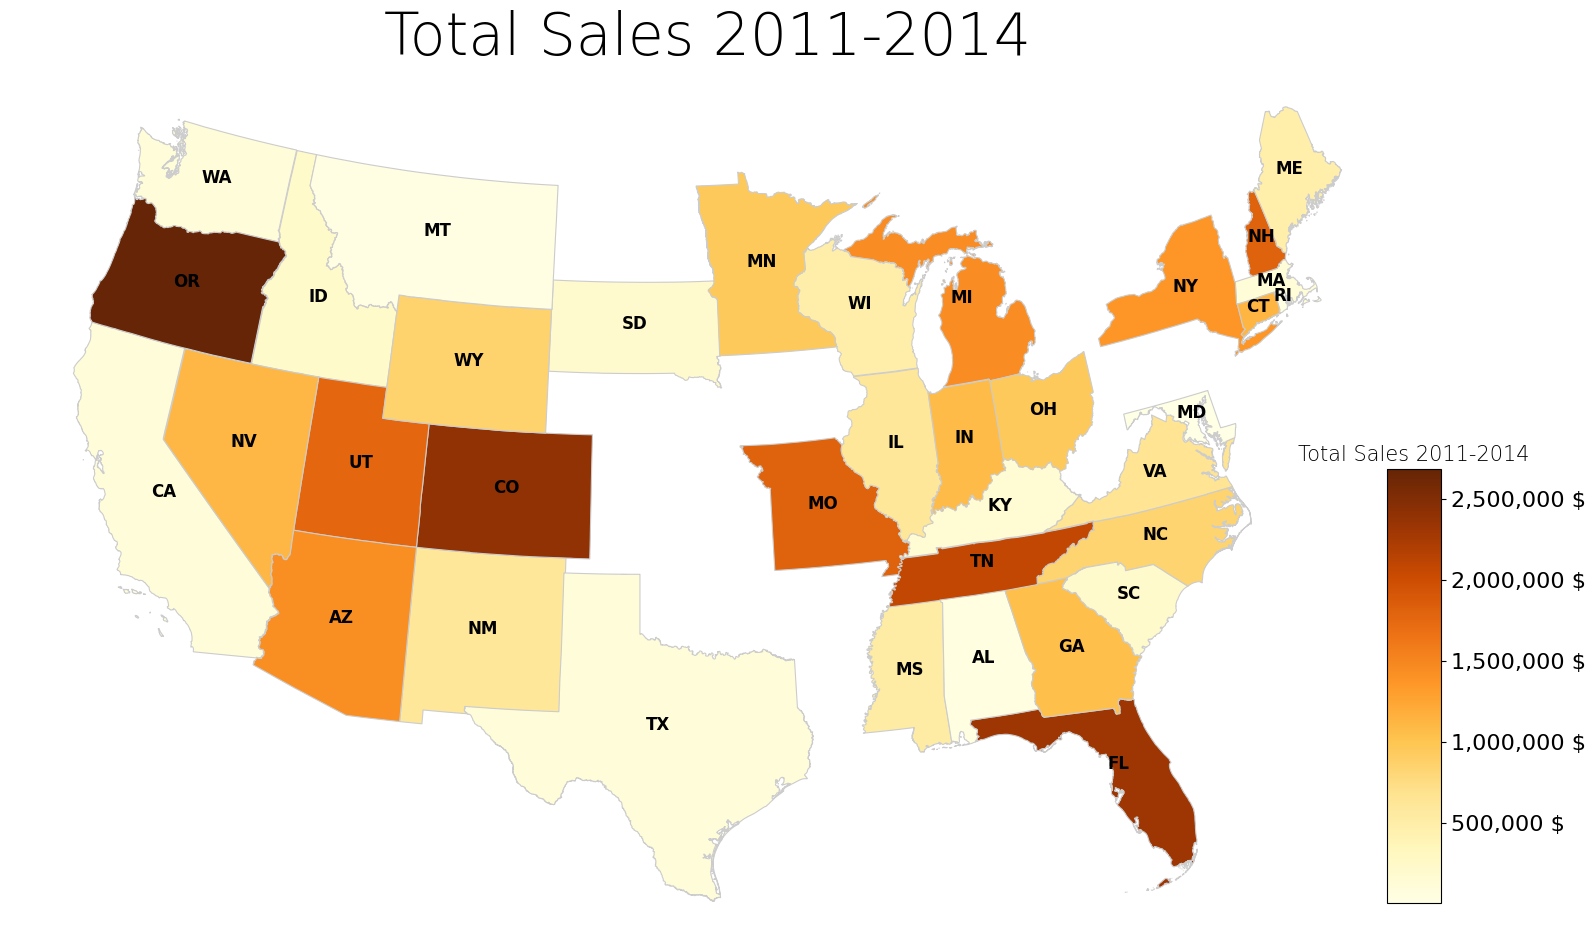

In [519]:

# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf


# Set the variable to be visualised

variable = 'TotalSales'

# Create the scale for the variable colour

vmin, vmax = gdf.TotalSales.min(), gdf.TotalSales.max()

# Choose the continuous colourscale YlOrBr

colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# I think it uses the coordinates in gdf visframe and converts them so they can be mapped onto a map of the USA (coordinates on a sphere onto a 2d map)

visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(18, 14))

# remove the axis box around the vis

ax.axis('off')

# add a title and annotation

ax.set_title('Total Sales 2011-2014', fontdict={'fontsize': '42', 'fontweight' : '1'})
# Create colorbar legend

fig = ax.get_figure()

# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Total Sales 2011-2014', fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))

# reformat tick labels on legend

comma_fmt = FuncFormatter(lambda x, _: f"{x:,.0f} $")
sm._A = []

fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
        
      # Get the state's subset  
        vf = visframe[visframe.StateProvinceCode==row.StateProvinceCode]

        # Get the assigned color
        c = gdf[gdf.StateProvinceCode==row.StateProvinceCode][0:1].value_determined_color.item()

        # Plot the state
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

        # Compute the centroid for labeling (geometry column assumed)
        centroid = vf.geometry.centroid.iloc[0]

        # Add state name label
        ax.text(centroid.x, centroid.y, row.StateProvinceCode, 
            fontsize=12, fontweight='bold', ha='center', color='black')
